In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


# Initialising the resnet50 model with weights on the ImageNet Dataset. 

In [1]:
from keras.models import Model, load_model
from keras.layers import Dense, Input, Activation, Flatten
from keras.layers import GlobalAveragePooling2D, LeakyReLU, Dropout
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import os
import random
import pickle
import json

Using TensorFlow backend.


In [10]:
# The sign Language dataset has images of shape 200 x 200 x 3 (colour)
# we will be experimenting with different image sizes as 200 is extremely large
# for a dataset such as this

my_input_image = Input(shape=(120,120,3))

# include_top = True means to include the top level layers that make the prediction
# we will remove their prediction layer but this is just to show properly how its done. 
model = ResNet50(input_tensor=my_input_image,include_top=True, weights='imagenet')

W0816 01:18:11.529816 10448 deprecation_wrapper.py:119] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 01:18:11.972244 10448 deprecation_wrapper.py:119] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 01:18:12.277777 10448 deprecation_wrapper.py:119] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0816 01:18:12.412341 10448 deprecation_wrapper.py:119] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Add on our own layers to the model
##### The plan here is to remove the last three layers (refer to model.summary() above) and add on our layers from 'add_32' layer. 

add on our layers

the plan is to add a activation layer, the test with the following methods

##### method 1:
+ add flatten(), 
+ add multiple Dense(),
+ add final Dense() with softmax activation. 

##### method 2:
+ add GlobalAveragePooling() 
+ add multiple Dense()
+ add final Dense() with softmax activation.

##### method 3:
+ remove only last layer
+ add only Dense() with softmax activation. 

method 2 is more related to how they did it originally with the addition to a few Denses. 

They also use activation but I will be trying with different activation functions to see 
if they have any affect on performance. 

If there is no significant affect to accuracy then I will use their activation layer and add my own single Dense layer.
I will also add dropouts to method 1 and test with other activation functions like 'elu' and 'PRelu'


### Method 1:

In [12]:
# take output from the add_32 layer
add_32 = model.get_layer('add_16').output

In [13]:
# why elu and LeakyRelu() as activation functions?
# ReLU was found to have the 'dead relu problem'
# where it always outputs the same value for any
# input. This was solved by other Relu offsets,
# some of which are used here

# I observerd a high validation loss hence in
# model 1 i added Dropout layers, which help with
# the overfitting problem of the model. 

activation = 'elu'

activation_1 = LeakyReLU()(add_32)
flatten_1 = Flatten()(activation_1)
dense_1 = Dense(1000, activation=activation)(flatten_1)
drop_1 = Dropout(0.5)(dense_1)

dense_2 = Dense(500, activation=activation)(drop_1)
drop_2 = Dropout(0.5)(dense_2)

dense_3 = Dense(100, activation=activation)(drop_2)
drop_3 = Dropout(0.5)(dense_3)

output = Dense(29, activation='softmax')(drop_3)

my_resnet_model_1 = Model(inputs=my_input_image, outputs= output)
my_resnet_model_1.summary()

W0816 01:18:38.025911 10448 deprecation.py:506] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
for layer in my_resnet_model_1.layers[:-6]:
    layer.trainable = False
    
for layer in my_resnet_model_1.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

### Method 2:

In [15]:
add_32 = model.get_layer('add_16').output

In [16]:
activation = 'elu'

activation_1 = LeakyReLU()(add_32)
GAP_1 = GlobalAveragePooling2D()(activation_1)
dense_1 = Dense(1000, activation=activation)(GAP_1)
drop_1 = Dropout(0.5)(dense_1)

dense_2 = Dense(500, activation=activation)(drop_1)
drop_2 = Dropout(0.5)(dense_2)

dense_3 = Dense(100, activation=activation)(drop_2)
drop_3 = Dropout(0.5)(dense_3)

output = Dense(29, activation='softmax')(drop_3)

my_resnet_model_2 = Model(inputs=my_input_image, outputs= output)
my_resnet_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

bn3d_branch2b (BatchNormalizati (None, 15, 15, 128)  512         res3d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 15, 15, 128)  0           bn3d_branch2b[0][0]              
__________________________________________________________________________________________________
res3d_branch2c (Conv2D)         (None, 15, 15, 512)  66048       activation_21[0][0]              
__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 15, 15, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 15, 15, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________

In [17]:
for layer in my_resnet_model_2.layers[:-6]:
    layer.trainable = False
    
for layer in my_resnet_model_2.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

### Method 3:

In [18]:
avg_pool = model.get_layer('avg_pool').output

In [19]:
output = Dense(29, activation='softmax')(avg_pool)

my_resnet_model_3 = Model(inputs=my_input_image, outputs= output)
my_resnet_model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
for layer in my_resnet_model_3.layers[:-1]:
    layer.trainable = False
    
for layer in my_resnet_model_3.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

# Load the data


In [21]:
#init img_size 

img_size = 120

In [22]:
# init the directories and all the possible classes we can have. We will use these classes as our class label too. 
# later these will be saved to a pickle file to avoid constant loading
asl_dataset_dir = 'asl_alphabet_train/'
asl_catagories = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [23]:
training_data = []

for category in asl_catagories:
    path = os.path.join(asl_dataset_dir, category) # creates the whole path to each sub dir
    class_num = asl_catagories.index(category)
    
    print(category) # Debug
    
    for img in os.listdir(path):
        
        img_array = cv2.imread(os.path.join(path, img), 1)
        
        img_array = cv2.resize(img_array, (img_size,img_size))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        
        training_data.append([img_array, class_num])
    

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
del
nothing
space


In [24]:
random.shuffle(training_data)

X = [] # feature set
Y = [] # label set

for feature, label in training_data:
    X.append(feature)
    Y.append(label)
    

In [0]:
# overhead - saving data so faster to load

with open('/transfer_learning/Data/X.pickle', 'wb') as X_out:
    pickle.dump(X, X_out, protocol=4)
    
with open('/transfer_learning/Data/Y.pickle', 'wb') as Y_out:
    pickle.dump(Y, Y_out, protocol=4)

In [16]:
with open('X.pickle', 'rb') as X_in:
    X = pickle.load(X_in)

with open('Y.pickle', 'rb') as Y_in:
    Y = pickle.load(Y_in)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

In [ ]:
# normalising the data - this takes some time.

X_train = np.array((X_train/255.)).reshape(-1, img_size, img_size, 3)
X_test = np.array((X_test/255.)).reshape(-1, img_size, img_size, 3)

Y_train, Y_test = np.array(Y_train), np.array(Y_test)

In [27]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(69580, 120, 120, 3) (17396, 120, 120, 3) (69580,) (17396,)


# compile and fit all models

In [28]:
# compile model
my_resnet_model_1.compile('sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

W0816 01:26:32.329251 10448 deprecation_wrapper.py:119] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [29]:
history_model_1 = my_resnet_model_1.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)

W0816 01:26:32.495289 10448 deprecation.py:323] From D:\ProgramData\Miniconda3\envs\msa\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55664 samples, validate on 13916 samples
Epoch 1/10
55664/55664 [==============================] - 136s 2ms/step - loss: 3.5439 - acc: 0.1350 - val_loss: 2.4598 - val_acc: 0.3191
Epoch 2/10
55664/55664 [==============================] - 119s 2ms/step - loss: 2.1542 - acc: 0.3713 - val_loss: 1.9831 - val_acc: 0.4077
Epoch 3/10
55664/55664 [==============================] - 120s 2ms/step - loss: 1.6613 - acc: 0.4936 - val_loss: 1.8966 - val_acc: 0.4340
Epoch 4/10
55664/55664 [==============================] - 120s 2ms/step - loss: 1.4321 - acc: 0.5547 - val_loss: 1.7890 - val_acc: 0.4602
Epoch 5/10
55664/55664 [==============================] - 120s 2ms/step - loss: 1.2991 - acc: 0.5926 - val_loss: 1.7827 - val_acc: 0.4636
Epoch 6/10
55664/55664 [==============================] - 120s 2ms/step - loss: 1.2030 - acc: 0.6193 - val_loss: 1.7396 - val_acc: 0.4758
Epoch 7/10
55664/55664 [==============================] - 117s 2ms/step - loss: 1.1265 - acc: 0.6436 - val_loss: 1.6871 - 

In [30]:
# compile model
my_resnet_model_2.compile('sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
history_model_2 = my_resnet_model_2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 55664 samples, validate on 13916 samples
Epoch 1/10
55664/55664 [==============================] - 132s 2ms/step - loss: 2.1817 - acc: 0.3922 - val_loss: 2.0068 - val_acc: 0.4085
Epoch 2/10
55664/55664 [==============================] - 132s 2ms/step - loss: 1.2802 - acc: 0.6012 - val_loss: 1.9130 - val_acc: 0.4502
Epoch 3/10
55664/55664 [==============================] - 133s 2ms/step - loss: 1.0993 - acc: 0.6537 - val_loss: 2.0230 - val_acc: 0.4345
Epoch 4/10
55664/55664 [==============================] - 134s 2ms/step - loss: 1.0069 - acc: 0.6812 - val_loss: 2.0334 - val_acc: 0.4399
Epoch 5/10
55664/55664 [==============================] - 128s 2ms/step - loss: 0.9359 - acc: 0.7024 - val_loss: 2.1053 - val_acc: 0.4317
Epoch 6/10
55664/55664 [==============================] - 133s 2ms/step - loss: 0.8992 - acc: 0.7126 - val_loss: 1.9960 - val_acc: 0.4532
Epoch 7/10
55664/55664 [==============================] - 133s 2ms/step - loss: 0.8570 - acc: 0.7267 - val_loss: 2.0717 - 

In [32]:
# compile model
my_resnet_model_3.compile('sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history_model_3 = my_resnet_model_3.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 55664 samples, validate on 13916 samples
Epoch 1/10
55664/55664 [==============================] - 133s 2ms/step - loss: 0.9438 - acc: 0.7836 - val_loss: 1.8559 - val_acc: 0.4721
Epoch 2/10
55664/55664 [==============================] - 132s 2ms/step - loss: 0.3733 - acc: 0.9232 - val_loss: 1.8981 - val_acc: 0.4767
Epoch 3/10
55664/55664 [==============================] - 127s 2ms/step - loss: 0.2685 - acc: 0.9478 - val_loss: 1.8586 - val_acc: 0.4950
Epoch 4/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.2181 - acc: 0.9575 - val_loss: 1.9067 - val_acc: 0.4920
Epoch 5/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.1847 - acc: 0.9641 - val_loss: 1.8859 - val_acc: 0.4999
Epoch 6/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.1642 - acc: 0.9689 - val_loss: 1.9240 - val_acc: 0.4981
Epoch 7/10
55664/55664 [==============================] - 131s 2ms/step - loss: 0.1451 - acc: 0.9741 - val_loss: 1.9098 - 

### overheads

In [34]:
my_resnet_model_1.save('my_resnet_model_1.h5')

In [35]:
my_resnet_model_2.save('my_resnet_model_2.h5')

In [36]:
my_resnet_model_3.save('my_resnet_model_3.h5')

In [42]:
with open('history_model_1.json', 'w') as f1,\
     open('history_model_2.json', 'w') as f2,\
     open('history_model_3.json', 'w') as f3:
        json.dump(history_model_1.history, f1)
        json.dump(history_model_2.history, f2)
        json.dump(history_model_3.history, f3)

In [43]:
with open('history_model_1.json', 'r') as f1,\
     open('history_model_2.json', 'r') as f2,\
     open('history_model_3.json', 'r') as f3:
        history_model_1 = json.loads(f1.read())
        history_model_2 = json.loads(f2.read())
        history_model_3 = json.loads(f3.read())

# Plotting outputs 

need to run overheads to run the below properly

### Method 1:

In [48]:
my_resnet_model_1 = load_model('my_resnet_model_1.h5')

In [45]:
train_loss_1 = history_model_1['loss']
val_loss_1 = history_model_1['val_loss']

Text(0.5, 1.0, 'Comparing train and val loss of method 1')

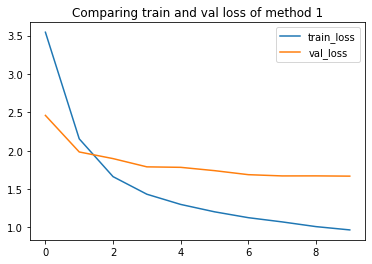

In [46]:
plt.plot(train_loss_1)
plt.plot(val_loss_1)

plt.legend(('train_loss', 'val_loss'))
plt.title('Comparing train and val loss of method 1')

In [104]:
for i in range(len(my_resnet_model_1.layers)):
	layer = my_resnet_model_1.layers[i]
    
	if 'res' not in layer.name and 'conv' not in layer.name:
		continue
        
	print(i, layer.name, layer.output.shape)
    

1 conv1_pad (?, 126, 126, 3)
2 conv1 (?, 60, 60, 64)
3 bn_conv1 (?, 60, 60, 64)
7 res2a_branch2a (?, 30, 30, 64)
10 res2a_branch2b (?, 30, 30, 64)
13 res2a_branch2c (?, 30, 30, 256)
14 res2a_branch1 (?, 30, 30, 256)
19 res2b_branch2a (?, 30, 30, 64)
22 res2b_branch2b (?, 30, 30, 64)
25 res2b_branch2c (?, 30, 30, 256)
29 res2c_branch2a (?, 30, 30, 64)
32 res2c_branch2b (?, 30, 30, 64)
35 res2c_branch2c (?, 30, 30, 256)
39 res3a_branch2a (?, 15, 15, 128)
42 res3a_branch2b (?, 15, 15, 128)
45 res3a_branch2c (?, 15, 15, 512)
46 res3a_branch1 (?, 15, 15, 512)
51 res3b_branch2a (?, 15, 15, 128)
54 res3b_branch2b (?, 15, 15, 128)
57 res3b_branch2c (?, 15, 15, 512)
61 res3c_branch2a (?, 15, 15, 128)
64 res3c_branch2b (?, 15, 15, 128)
67 res3c_branch2c (?, 15, 15, 512)
71 res3d_branch2a (?, 15, 15, 128)
74 res3d_branch2b (?, 15, 15, 128)
77 res3d_branch2c (?, 15, 15, 512)
81 res4a_branch2a (?, 8, 8, 256)
84 res4a_branch2b (?, 8, 8, 256)
87 res4a_branch2c (?, 8, 8, 1024)
88 res4a_branch1 (?, 8, 

In [106]:
def get_feature_model_gen_1(layer = 100, step = 3):
    for i in range(1, layer, step):
        if 'res' not in my_resnet_model_1.layers[i].name and 'conv' not in my_resnet_model_1.layers[i].name:
            continue
            
        yield Model(inputs=my_resnet_model_1.inputs, outputs=my_resnet_model_1.layers[i].output)

In [107]:
X_test = X_test.reshape(-1, img_size, img_size, 3)

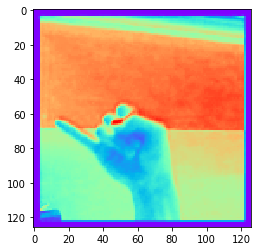

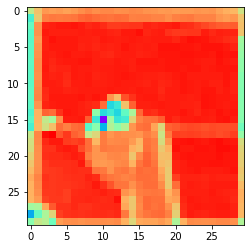

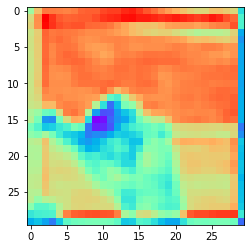

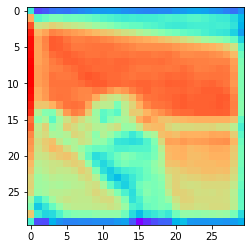

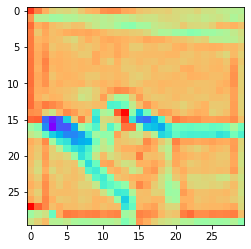

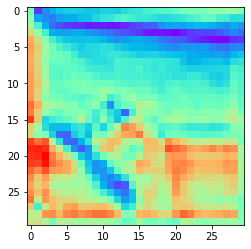

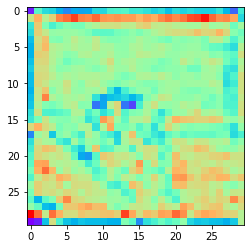

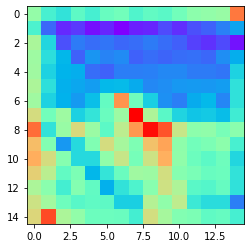

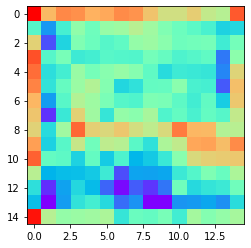

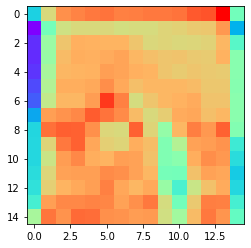

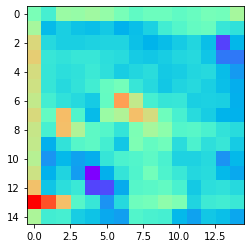

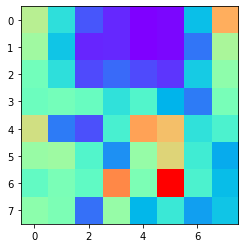

In [108]:
for feature_model in get_feature_model_gen_1():
    feature_maps = feature_model.predict(X_test[:1])
    
    plt.imshow(feature_maps[0, :, :, 0], cmap='rainbow')
    plt.show()
            

### Method 2:

In [0]:
my_resnet_model_2 = load_model('transfer_learning/Data/my_resnet_model_2.h5')

In [117]:
train_loss_2 = history_model_2['loss']
val_loss_2 = history_model_2['val_loss']

Text(0.5, 1.0, 'Comparing train and val loss of method 2')

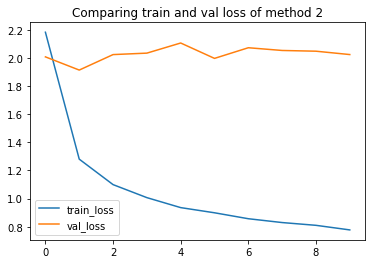

In [118]:
plt.plot(train_loss_2)
plt.plot(val_loss_2)

plt.legend(('train_loss', 'val_loss'))
plt.title('Comparing train and val loss of method 2')

In [88]:
for i in range(len(my_resnet_model_2.layers)):
	layer = my_resnet_model_2.layers[i]
    
	if 'res' not in layer.name:
		continue
        
	print(i, layer.name, layer.output.shape)

7 res2a_branch2a (?, 30, 30, 64)
10 res2a_branch2b (?, 30, 30, 64)
13 res2a_branch2c (?, 30, 30, 256)
14 res2a_branch1 (?, 30, 30, 256)
19 res2b_branch2a (?, 30, 30, 64)
22 res2b_branch2b (?, 30, 30, 64)
25 res2b_branch2c (?, 30, 30, 256)
29 res2c_branch2a (?, 30, 30, 64)
32 res2c_branch2b (?, 30, 30, 64)
35 res2c_branch2c (?, 30, 30, 256)
39 res3a_branch2a (?, 15, 15, 128)
42 res3a_branch2b (?, 15, 15, 128)
45 res3a_branch2c (?, 15, 15, 512)
46 res3a_branch1 (?, 15, 15, 512)
51 res3b_branch2a (?, 15, 15, 128)
54 res3b_branch2b (?, 15, 15, 128)
57 res3b_branch2c (?, 15, 15, 512)
61 res3c_branch2a (?, 15, 15, 128)
64 res3c_branch2b (?, 15, 15, 128)
67 res3c_branch2c (?, 15, 15, 512)
71 res3d_branch2a (?, 15, 15, 128)
74 res3d_branch2b (?, 15, 15, 128)
77 res3d_branch2c (?, 15, 15, 512)
81 res4a_branch2a (?, 8, 8, 256)
84 res4a_branch2b (?, 8, 8, 256)
87 res4a_branch2c (?, 8, 8, 1024)
88 res4a_branch1 (?, 8, 8, 1024)
93 res4b_branch2a (?, 8, 8, 256)
96 res4b_branch2b (?, 8, 8, 256)
99 re

In [109]:
def get_feature_model_gen_2(layer = 100, step = 4):
    for i in range(1, layer, step):
        if 'res' not in my_resnet_model_1.layers[i].name and 'conv' not in my_resnet_model_1.layers[i].name:
            continue
            
        yield Model(inputs=my_resnet_model_2.inputs, outputs=my_resnet_model_2.layers[i].output)

In [110]:
X_test = X_test.reshape(-1, img_size, img_size, 3)

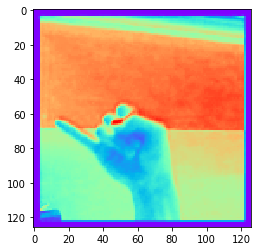

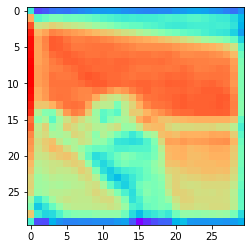

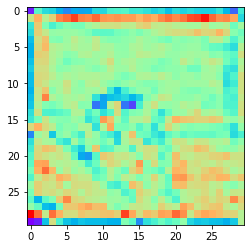

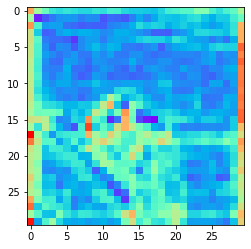

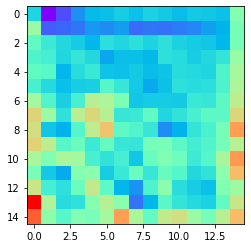

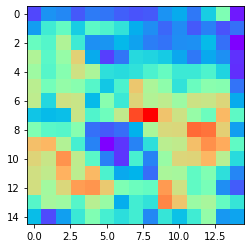

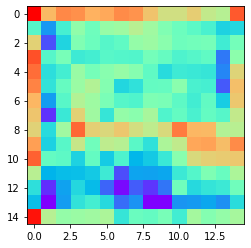

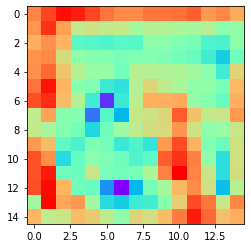

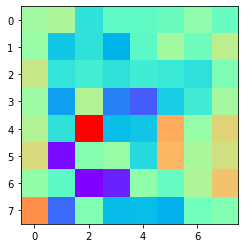

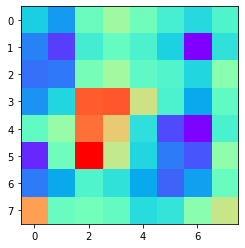

In [111]:
for feature_model in get_feature_model_gen_2():
    feature_maps = feature_model.predict(X_test[:1])
    
    plt.imshow(feature_maps[0, :, :, 0], cmap='rainbow')
    plt.show()

### Method 3:

In [0]:
my_resnet_model_3 = load_model('transfer_learning/Data/my_resnet_model_3.h5')

W0814 12:55:47.298119 139827689961344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 12:55:47.381178 139827689961344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0814 12:55:47.432780 139827689961344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 12:55:47.434277 139827689961344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 12:55:47.43551

In [119]:
train_loss_3 = history_model_3['loss']
val_loss_3 = history_model_3['val_loss']

Text(0.5, 1.0, 'Comparing train and val loss of method 3')

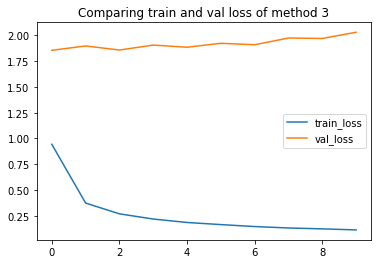

In [120]:
plt.plot(train_loss_3)
plt.plot(val_loss_3)

plt.legend(('train_loss', 'val_loss'))
plt.title('Comparing train and val loss of method 3')

In [98]:
for i in range(len(my_resnet_model_2.layers)):
	layer = my_resnet_model_2.layers[i]
    
	if 'res' not in layer.name:
		continue
        
	print(i, layer.name, layer.output.shape)

7 res2a_branch2a (?, 30, 30, 64)
10 res2a_branch2b (?, 30, 30, 64)
13 res2a_branch2c (?, 30, 30, 256)
14 res2a_branch1 (?, 30, 30, 256)
19 res2b_branch2a (?, 30, 30, 64)
22 res2b_branch2b (?, 30, 30, 64)
25 res2b_branch2c (?, 30, 30, 256)
29 res2c_branch2a (?, 30, 30, 64)
32 res2c_branch2b (?, 30, 30, 64)
35 res2c_branch2c (?, 30, 30, 256)
39 res3a_branch2a (?, 15, 15, 128)
42 res3a_branch2b (?, 15, 15, 128)
45 res3a_branch2c (?, 15, 15, 512)
46 res3a_branch1 (?, 15, 15, 512)
51 res3b_branch2a (?, 15, 15, 128)
54 res3b_branch2b (?, 15, 15, 128)
57 res3b_branch2c (?, 15, 15, 512)
61 res3c_branch2a (?, 15, 15, 128)
64 res3c_branch2b (?, 15, 15, 128)
67 res3c_branch2c (?, 15, 15, 512)
71 res3d_branch2a (?, 15, 15, 128)
74 res3d_branch2b (?, 15, 15, 128)
77 res3d_branch2c (?, 15, 15, 512)
81 res4a_branch2a (?, 8, 8, 256)
84 res4a_branch2b (?, 8, 8, 256)
87 res4a_branch2c (?, 8, 8, 1024)
88 res4a_branch1 (?, 8, 8, 1024)
93 res4b_branch2a (?, 8, 8, 256)
96 res4b_branch2b (?, 8, 8, 256)
99 re

In [114]:
def get_feature_model_gen_3(layer = 100, step = 4):
    for i in range(1, layer, step):
        if 'res' not in my_resnet_model_1.layers[i].name and 'conv' not in my_resnet_model_1.layers[i].name:
            continue
            
        yield Model(inputs=my_resnet_model_3.inputs, outputs=my_resnet_model_3.layers[i].output)

In [115]:
X_test = X_test.reshape(-1, img_size, img_size, 3)

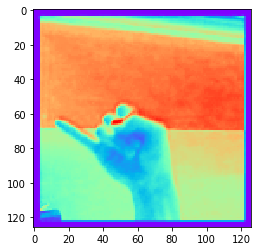

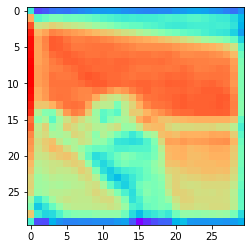

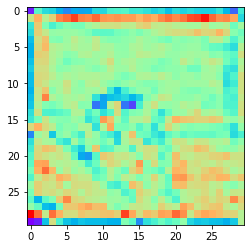

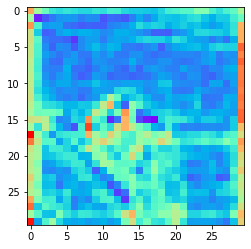

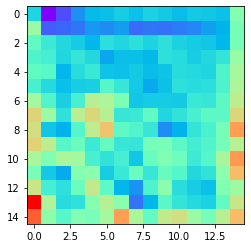

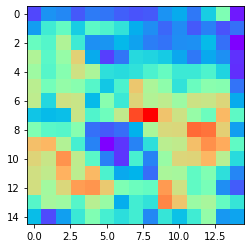

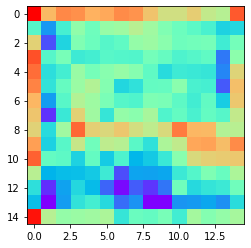

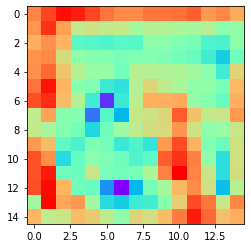

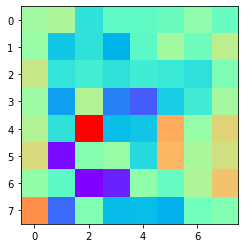

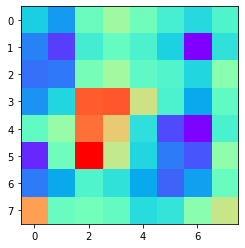

In [116]:
for feature_model in get_feature_model_gen_3():
    feature_maps = feature_model.predict(X_test[:1])
    
    plt.imshow(feature_maps[0, :, :, 0], cmap='rainbow')
    plt.show()

From the above we can see the plots of val loss and train loss for each method we used. We also output a feature map of the various convolution layers from all 3 of your models. We can see that in the initial layers the edges, curves are being activated but its mostly the background and other irrelavant information. This could prove our validation accuracy and loss values. 